In [1]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import dgl.nn as dglnn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from mutagDataset import MUTAG

In [2]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

data = MUTAG()

num_examples = len(data)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    data, sampler=train_sampler)
test_dataloader = GraphDataLoader(
    data, sampler=test_sampler)

In [3]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv3 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv4 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')
        
        
    def forward(self, graph, inputs):
        # inputs is features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.normalize(v) for k, v in h.items()}
        h = {k: F.leaky_relu(v) for k, v in h.items()}
        
        h = self.conv2(graph, h)
        h = {k: F.leaky_relu(v) for k, v in h.items()}
    
        h = self.conv3(graph, h)
        h = {k: F.leaky_relu(v) for k, v in h.items()}
        
        h = self.conv4(graph, h)
        h = {k: F.dropout(v, p=0.5) for k, v in h.items()}
        return h

class HeteroClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes, rel_names):
        super().__init__()
        self.in_dim = in_dim
        self.rgcn = RGCN(in_dim, hidden_dim, hidden_dim, rel_names)
        self.linear = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, feat=None, eweight=None):
        if not feat:
            feat = {ntype:torch.zeros((g.num_nodes(ntype), self.in_dim)) for ntype in g.ntypes}
    
        h = feat    
        h = self.rgcn(g, h)

        with g.local_scope():
            g.ndata['h'] = h
    
            if eweight is None:
                g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
            else:
                g.edata['w'] = eweight
                g.update_all(fn.u_mul_e('h', 'w', 'm'), fn.sum('m', 'h'))
                
            # Calculate graph representation by average readout.
            hg = 0
            for ntype in g.ntypes: 
                hg = hg + dgl.mean_nodes(g, 'h', ntype=ntype)
            return torch.sigmoid(self.linear(hg))


In [4]:
rel_names = set()

for graph in data:
    for edge in graph[0].etypes:
        rel_names.add(str(edge))

rel_names = list(rel_names)

In [5]:
# model = HeteroClassifier(10, 30, 2, rel_names)
# model = torch.load('./MUTAG_Trained_Model.pt')
# training_loss, test_loss = [], []

In [ ]:
# opt = torch.optim.Adam(model.parameters(), lr=0.02)

# for epoch in range(100):
#     num_correct, num_tests, batchLoss = 0, 0, 0
#     for batched_graph, labels in train_dataloader:
#         logits = model(batched_graph)
#         loss = F.cross_entropy(logits, labels)
#         opt.zero_grad()
#         loss.backward()
        
#         nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
#         opt.step()
        
#         batchLoss+= loss
#         num_correct += (logits.argmax(1) == labels).sum().item()
#         num_tests += len(labels)

#     training_loss.append(batchLoss/num_tests)
    
#     num_correct_test, num_tests_t = 0, 0 
#     batchTestLoss = 0
#     for batched_graph, labels in test_dataloader:
#         pred = model(batched_graph)
#         loss = F.cross_entropy(pred, labels)
#         num_correct_test += (pred.argmax(1) == labels).sum().item()
#         num_tests_t += len(labels)        
#         batchTestLoss += loss

#     test_loss.append(batchTestLoss/num_tests)
    
#     if epoch % 3 == 0:
#         print(f'Epoch {epoch}, Train accuracy: {num_correct / num_tests * 100:.2f}%, Test accuracy: {num_correct_test / num_tests_t * 100:.2f}%')
    
#     if epoch % 30 == 0 and epoch != 0:
#         torch.save(model, './MUTAG_Trained_Model.pt')

/Users/tk178/opt/anaconda3/envs/torchenv/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 0, Train accuracy: 81.33%, Test accuracy: 63.16%
Epoch 3, Train accuracy: 80.00%, Test accuracy: 86.84%
Epoch 6, Train accuracy: 76.67%, Test accuracy: 73.68%
Epoch 9, Train accuracy: 82.00%, Test accuracy: 76.32%
Epoch 12, Train accuracy: 84.00%, Test accuracy: 76.32%
Epoch 15, Train accuracy: 84.00%, Test accuracy: 86.84%
Epoch 18, Train accuracy: 83.33%, Test accuracy: 84.21%
Epoch 21, Train accuracy: 82.00%, Test accuracy: 86.84%
Epoch 24, Train accuracy: 82.00%, Test accuracy: 84.21%
Epoch 27, Train accuracy: 83.33%, Test accuracy: 84.21%
Epoch 30, Train accuracy: 83.33%, Test accuracy: 76.32%
Epoch 33, Train accuracy: 78.00%, Test accuracy: 81.58%
Epoch 36, Train accuracy: 82.67%, Test accuracy: 76.32%


In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(training_loss, label='train_loss')
# plt.plot(test_loss, label='test_loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.show()

In [17]:
def createMaskMeanDict(mask):
    maskMean = {}
    for key in mask:
        if list(mask[key]):
            maskMean[key] =  torch.mean(mask[key])
    return maskMean

def getMaxKey(dictionary):
    maxKey = None
    maxValue = 0
    for key in dictionary:
        if dictionary[key] > maxValue:
            maxValue = dictionary[key]
            maxKey = key
    
    return maxKey, maxValue

In [116]:
# model = torch.save(model, './MUTAG_Trained_Model.pt')
model = torch.load('./MUTAG_Trained_Model.pt')

In [11]:
dataloader = GraphDataLoader(data)

num_correct, num_tests = 0, 0
for batched_graph, labels in dataloader:
    pred = model(batched_graph)
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print(f'Accuracy: {num_correct / num_tests * 100:.2f}%')

Accuracy: 83.51%


In [22]:
from gnnexplainer import HeteroGNNExplainer

mostIndicativeNode = []
mostIndicativeEdge = []

for i in range(188):
    g = data[i][0]
    feat = {ntype:torch.zeros((g.num_nodes(ntype), 10)) for ntype in g.ntypes}
    explainer = HeteroGNNExplainer(model, num_hops=4, log=False)
    feat_mask, edge_mask = explainer.explain_graph(g, feat)
    mostIndicativeNode.append(getMaxKey(createMaskMeanDict(feat_mask))[0])
    mostIndicativeEdge.append(getMaxKey(createMaskMeanDict(edge_mask))[0])

In [30]:
from collections import Counter

importantNodes = Counter(mostIndicativeNode)
importantEdges = Counter(mostIndicativeEdge)

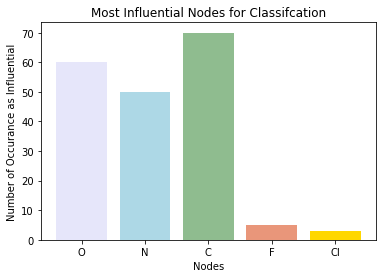

In [79]:
import matplotlib.pyplot as plt

x = importantNodes.keys()
height = importantNodes.values()
color = ['lavender', 'lightBlue', 'darkSeaGreen', 'darkSalmon', 'gold']

plt.bar(x, height, color=color)
plt.xlabel('Nodes')
plt.ylabel('Number of Occurance as Influential')
plt.title('Most Influential Nodes for Classifcation')
# plt.savefig('Influential_Nodes_Bar.jpg', dpi=150, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto')
plt.show()

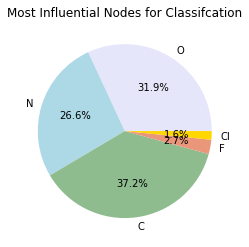

In [74]:
color = ['lavender', 'lightBlue', 'darkSeaGreen', 'darkSalmon', 'gold']
plt.pie(x=height, labels=x, autopct='%1.1f%%', colors=color)
plt.title('Most Influential Nodes for Classifcation')
# plt.savefig('Influential_Nodes_Pie.jpg', dpi=150, pad_inches=0.1,
#             facecolor='auto', edgecolor='auto')
plt.show()

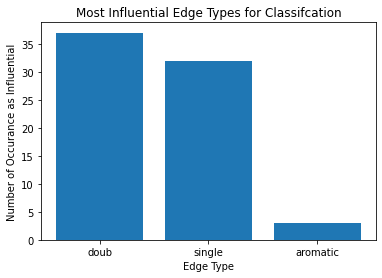

In [106]:
import matplotlib.pyplot as plt

x = list(map(lambda x: str(x[1]), importantEdges.keys()))
height = importantEdges.values()
# color = ['lavender', 'lightBlue', 'darkSeaGreen', 'darkSalmon', 'gold']
# x = ['Double', 'Single', 'Aromatic']
plt.bar(x, height)
plt.xlabel('Edge Type')
plt.ylabel('Number of Occurance as Influential')
plt.title('Most Influential Edge Types for Classifcation')
plt.savefig('Influential_Etype_Bar.jpg', dpi=150, pad_inches=0.1,
        facecolor='auto', edgecolor='auto')
plt.show()

In [107]:
mostIndicativeEdge

[('O', 'doub', 'N'),
 ('O', 'single', 'N'),
 ('O', 'doub', 'N'),
 ('N', 'single', 'O'),
 ('O', 'doub', 'N'),
 ('N', 'single', 'C'),
 ('O', 'single', 'N'),
 ('N', 'single', 'C'),
 ('O', 'single', 'N'),
 ('O', 'single', 'N'),
 ('N', 'single', 'C'),
 ('N', 'doub', 'O'),
 ('N', 'single', 'C'),
 ('N', 'single', 'N'),
 ('N', 'single', 'O'),
 ('N', 'single', 'C'),
 ('O', 'doub', 'N'),
 ('N', 'single', 'O'),
 ('C', 'single', 'N'),
 ('O', 'doub', 'N'),
 ('O', 'single', 'N'),
 ('N', 'single', 'O'),
 ('N', 'single', 'C'),
 ('N', 'doub', 'O'),
 ('N', 'single', 'O'),
 ('N', 'single', 'O'),
 ('C', 'aromatic', 'C'),
 ('O', 'doub', 'N'),
 ('O', 'doub', 'N'),
 ('O', 'doub', 'N'),
 ('N', 'single', 'O'),
 ('N', 'single', 'O'),
 ('O', 'doub', 'N'),
 ('O', 'single', 'N'),
 ('N', 'single', 'O'),
 ('C', 'single', 'N'),
 ('C', 'single', 'N'),
 ('N', 'single', 'O'),
 ('O', 'single', 'C'),
 ('N', 'doub', 'O'),
 ('N', 'single', 'C'),
 ('N', 'doub', 'O'),
 ('O', 'single', 'N'),
 ('O', 'doub', 'N'),
 ('C', 'aromat